# Comparison of a simulated and a real trace of HPL

In [1]:
import io
import os
import zipfile
import pandas
import yaml
from plotnine import *
import plotnine
import sys
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x, usecols=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

In [2]:
reality_archive = 'geometry/6/grenoble_2020-07-09_1939973.zip'
simgrid_dir = '../smpi_hpl/geometry/22/'
simgrid_archives = [os.path.join(simgrid_dir, f) for f in os.listdir(simgrid_dir)]
sizes = list(read_csv(reality_archive, 'results.csv').matrix_size)
for archive in simgrid_archives:
    assert sizes == list(read_csv(archive, 'results.csv').matrix_size)
print(sizes)

[250000]


In [3]:
def filter_pajeng(pajeng_output, keep):
    lines = pajeng_output.split(b'\n')
    lines = [l for l in lines if l.startswith(keep.encode())]
    return b'\n'.join(lines)

def _read_paje_state(archive_name, csv_name, has_msg_size=False, replace_func=('MPI', 'MPI')):
    columns=['type', 'rank', 'container', 'start', 'end', 'duration', 'level', 'function']
    if has_msg_size:
        columns.append('tmp')
    df = read_csv(archive_name, csv_name, columns=columns, filter_func=lambda x: filter_pajeng(x, 'State'))
    df['function'] = df['function'].str.replace(*replace_func).str.strip()  # for some reason Simgrid uses PMPI_Wait and not MPI_Wait
    df['msg_size'] = -1
    if has_msg_size:
        df.loc[df['function'].isin(['MPI_Recv', 'MPI_Send', 'MPI_Isend', 'MPI_Irecv']), 'msg_size'] = df['tmp']
        df['msg_size'] = df['msg_size'].astype(int)
    df['rank'] = df['rank'].str.slice(5).astype(int)  # changing 'rank42' into 42
    return df

def read_mpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name, True)
    return df

def read_smpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name, True, ('PMPI', 'MPI'))
    df['rank'] = -df['rank']  # in SMPI, we have 'rank-42' and not 'rank42', so there remains a - that we should remove
    return df

def read_smpi_link(archive_name, csv_name):
    df = read_csv(archive_name, csv_name,
                  columns=['type', 'level', 'container', 'start', 'end', 'duration', 'commType', 'src', 'dst', 'msg_size'],
                  filter_func=lambda x: filter_pajeng(x, 'Link'))
    df['src'] = df['src'].str.slice(6).astype(int)  # changing 'rank42' into 42
    df['dst'] = df['dst'].str.slice(6).astype(int)  # changing 'rank42' into 42
#    df['remote'] = (df['src'] // 32) != (df['dst'] // 32)
    return df

def read_archive(archive_name, mode, exp_id, drop_func=['MPI_Comm_rank', 'MPI_Comm_size', 'MPI_Comm_split', 'MPI_Comm_free', 'MPI_Init', 'MPI_Finalize']):
    assert mode in ('reality', 'simgrid')
    print('# Mode: %s' % mode)
    blas_col = ['file', 'line', 'function', 'rank', 'timestamp', 'duration', 'm', 'n', 'k']
    blas_trace = read_csv(archive_name, 'trace_blas_%d.csv' % exp_id, columns=blas_col)
    old_len = len(blas_trace)
   # blas_trace = blas_trace[(blas_trace['m'] != 0) & (blas_trace['n'] != 0) & (blas_trace['k'] != 0)]
    print('\tBLAS trace: %6d lines (removed %d lines with null sizes)' % (len(blas_trace), old_len - len(blas_trace)))
    blas_trace['start'] = blas_trace.timestamp
    blas_trace['end'] = blas_trace.timestamp + blas_trace.duration
#    blas_trace = blas_trace[['function', 'start', 'end', 'rank', 'm', 'n', 'k']]
    blas_trace['msg_size'] = -1
    blas_trace['kind'] = 'BLAS'
    if mode == 'reality':
        mpi_trace = read_mpi_state(archive_name, 'trace_mpi_%d.csv' % exp_id)
    else:
        mpi_trace = read_smpi_state(archive_name, 'trace_mpi_%d.csv' % exp_id)
    print('\tMPI  trace: %6d lines' % len(mpi_trace))
    mpi_trace = mpi_trace[['function', 'start', 'end', 'rank', 'msg_size']]
    mpi_trace['kind'] = 'MPI'
    df = pandas.concat([blas_trace, mpi_trace])
    df['mode'] = mode
    df['rank+1'] = df['rank'] + 1
    old_len = len(df)
    df = df[~df['function'].str.strip().isin(drop_func)]
    print('Removed %d events with functions in %s' % (old_len-len(df), ', '.join(drop_func)))
    df['duration'] = df['end'] - df['start']
    df['function'] = df['function'].str.strip()
    return df

traces = None
nbrow_limit = 2000000
for i, size in enumerate(sizes):
    print('Exp %d (matrix_size=%d)' % (i, size))
    for filename, mode in [(reality_archive, 'reality')] + [(archive, 'simgrid') for archive in simgrid_archives]:
        tmp_trace = read_archive(filename, mode, i)
        tmp_trace['matrix_size'] = size
#        if len(tmp_trace) > nbrow_limit:
#            sys.stderr.write('WARNING: dataframe for exp %d (matrix_size=%d) has %d rows, keeping %d' % (i, size, len(tmp_trace), nbrow_limit))
#        tmp_trace = tmp_trace.head(n=nbrow_limit)
        if mode == 'simgrid':
            expfiles = get_yaml(filename, 'info.yaml')['expfile']
            dgemmfile = [f for f in expfiles if f.endswith('.yaml')]
            assert len(dgemmfile) == 1
            tmp_trace['dgemm_file'] = dgemmfile[0]
        if traces is not None:
            traces = pandas.concat([traces, tmp_trace])
        else:
            traces = tmp_trace

traces.head()

Exp 0 (matrix_size=250000)
# Mode: reality
	BLAS trace:  45784 lines (removed 0 lines with null sizes)
	MPI  trace:  64812 lines
Removed 31206 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize
# Mode: simgrid
	BLAS trace: 367410 lines (removed 0 lines with null sizes)
	MPI  trace:  23070 lines
Removed 960 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize
# Mode: simgrid


/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:21: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


	BLAS trace: 232428 lines (removed 0 lines with null sizes)
	MPI  trace:  23070 lines
Removed 960 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize
# Mode: simgrid
	BLAS trace: 280866 lines (removed 0 lines with null sizes)
	MPI  trace:  23070 lines
Removed 960 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize
# Mode: simgrid
	BLAS trace: 262962 lines (removed 0 lines with null sizes)
	MPI  trace:  23070 lines
Removed 960 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize


,dgemm_file,duration,end,file,function,k,kind,line,m,matrix_size,mode,msg_size,n,rank,rank+1,start,timestamp
0,NaN,0.000000,4.103116,../HPL_pdtest.c,smpi_marker,NaN,BLAS,202.0,NaN,250000,reality,-1,NaN,0,1,4.103116,4.103116
1,NaN,0.000192,4.103359,../HPL_dlocmax.c,idamax,NaN,BLAS,125.0,250000.0,250000,reality,-1,NaN,0,1,4.103167,4.103167
2,NaN,0.000014,4.103377,../HPL_pdmxswp.c,dcopy,NaN,BLAS,165.0,128.0,250000,reality,-1,NaN,0,1,4.103363,4.103363
3,NaN,0.000003,4.103382,../HPL_pdmxswp.c,dcopy,NaN,BLAS,167.0,128.0,250000,reality,-1,NaN,0,1,4.103379,4.103379
4,NaN,0.000182,4.103570,../HPL_pdpancrT.c,dscal,NaN,BLAS,214.0,249999.0,250000,reality,-1,NaN,0,1,4.103388,4.103388


## HPL result

In [4]:
res = read_csv(reality_archive, 'results.csv')
res[['matrix_size', 'time']].sort_values(by='matrix_size')

,matrix_size,time
0,250000,56.81


In [5]:
res = []
for archive in simgrid_archives:
    tmp = read_csv(archive, 'results.csv')
    res.append(tmp)
res = pandas.concat(res)
res[['matrix_size', 'time']].sort_values(by='matrix_size')

,matrix_size,time
0,250000,35.16
0,250000,31.04
0,250000,32.32
0,250000,31.78


## Checking the parameters

In [6]:
parameters = read_csv(simgrid_archives[0], 'exp_hpl.csv')
for archive in simgrid_archives:
    assert read_csv(archive, 'exp_hpl.csv').equals(parameters)
parameters

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process
0,250000,128,1,480,1,2,2,1,0,8,32,1


In [7]:
read_csv(reality_archive, 'exp_hpl.csv')

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process
0,250000,128,1,480,1,2,2,1,0,8,32,1


In [8]:
platforms = set([zipfile.ZipFile(archive).read('dahu.xml').decode('ascii') for archive in simgrid_archives])
assert len(platforms) == 1
print(platforms.pop())

<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.965491847282898e-07:9.63619592297199e-11;8133:4.117386759387727e-06:9.998650637323814e-11;15831:3.901910334928982e-06:1.1003492469181915e-10;33956:8.556208528368661e-06:1.2636592924112397e-10;64000:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375236e-06:8.456019002037162e-11;8133:1.0616877366305338e-06:1.0399801951417905e-10;15831:1.1989168715510673e-06:9.880880432093221e-11;33956:1.3028804423006338e-06:1.0742263180618875e-10;64000:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.931229521083401e-07:7.051204536228214e-11;8133:3.601990790153244e-07:1.2449128895712037e-10;15831:2.97701688103096e-06:4.1302612649640425e-11;33956:3.133466154066955e-06:3.293458765281899e-11;64000:6.939993663604069e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4955575510466301;8133:5.649491428460

In [9]:
from IPython.display import display, Markdown
for archive in simgrid_archives:
    installfile = get_yaml(archive, 'info.yaml')['installfile']
    installfile_content = zipfile.ZipFile(archive).read(installfile).decode()
    display(Markdown('Archive name: %s' % archive))
    display(Markdown('```yaml\n%s\n```' % installfile_content))

/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:21: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Archive name: ../smpi_hpl/geometry/22/grenoble_2020-08-12_1944034.zip

```yaml
trace_execution: True
terminate_early: True
insert_bcast: True
stochastic_network: True
stochastic_cpu: True
disable_hpl_kernels: False
disable_nondgemm_randomness: False
random_seed: 105

```

Archive name: ../smpi_hpl/geometry/22/grenoble_2020-08-12_1944036.zip

```yaml
trace_execution: True
terminate_early: True
insert_bcast: True
stochastic_network: True
stochastic_cpu: True
disable_hpl_kernels: False
disable_nondgemm_randomness: False
random_seed: 105

```

Archive name: ../smpi_hpl/geometry/22/grenoble_2020-08-12_1944033.zip

```yaml
trace_execution: True
terminate_early: True
insert_bcast: True
stochastic_network: True
stochastic_cpu: True
disable_hpl_kernels: False
disable_nondgemm_randomness: False
random_seed: 105

```

Archive name: ../smpi_hpl/geometry/22/grenoble_2020-08-12_1944035.zip

```yaml
trace_execution: True
terminate_early: True
insert_bcast: True
stochastic_network: True
stochastic_cpu: True
disable_hpl_kernels: False
disable_nondgemm_randomness: False
random_seed: 105

```

In [10]:
non_null_traces = traces[(traces['m'] != 0) & (traces['n'] != 0) & (traces['k'] != 0)].copy()
print(len(non_null_traces), len(traces))
non_null_traces['func'] = non_null_traces['function']
non_null_traces.loc[~non_null_traces['function'].isin(['dgemm', 'dtrsm', 'MPI_Send', 'MPI_Recv']), 'func'] = 'other'

345211 1311496


## Visualizing the trace (non-null sizes)

In [11]:
def plot(df, wrap=None, lines=[], hard_lines=False):
    gc = ggplot(df) + geom_rect(aes(xmin='start', xmax='end', ymin='rank', ymax='rank+1',fill='func')) + theme_bw()
    if wrap:
        gc = gc + facet_wrap(wrap, labeller='label_both', ncol=2)
        guide = False
    else:
        guide = 'legend'
    gc = gc + scale_fill_brewer(type='qualitative', palette='Dark2', guide=guide)
    if lines:
        gc = gc + scale_x_continuous(breaks = lines) + expand_limits(x=max(lines))
        if hard_lines:
            for line in lines:
                gc = gc + geom_vline(xintercept=line, linetype='dashed', alpha=0.5)
    return gc

def plot_bounded(df, start, end, ranks, wrap=['mode', 'kind']):
    df = df[df['rank'].isin(ranks)]
    df = df[(df['end'] >= start) & (df['start'] <= end)].copy()
    df.loc[df['start'] < start, 'start'] = start
    df.loc[df['end'] > end, 'end'] = end
    return plot(df, wrap) + xlim(start, end) + ggtitle('Events between %.1fs and %.1fs for ranks in %s' % (start, end, ranks))

def my_range(start, stop, nb_steps):
    interval = (stop-start)/(nb_steps+1)
    val = start
    result = []
    for _ in range(nb_steps+2):
        result.append(val)
        val += interval
    return result

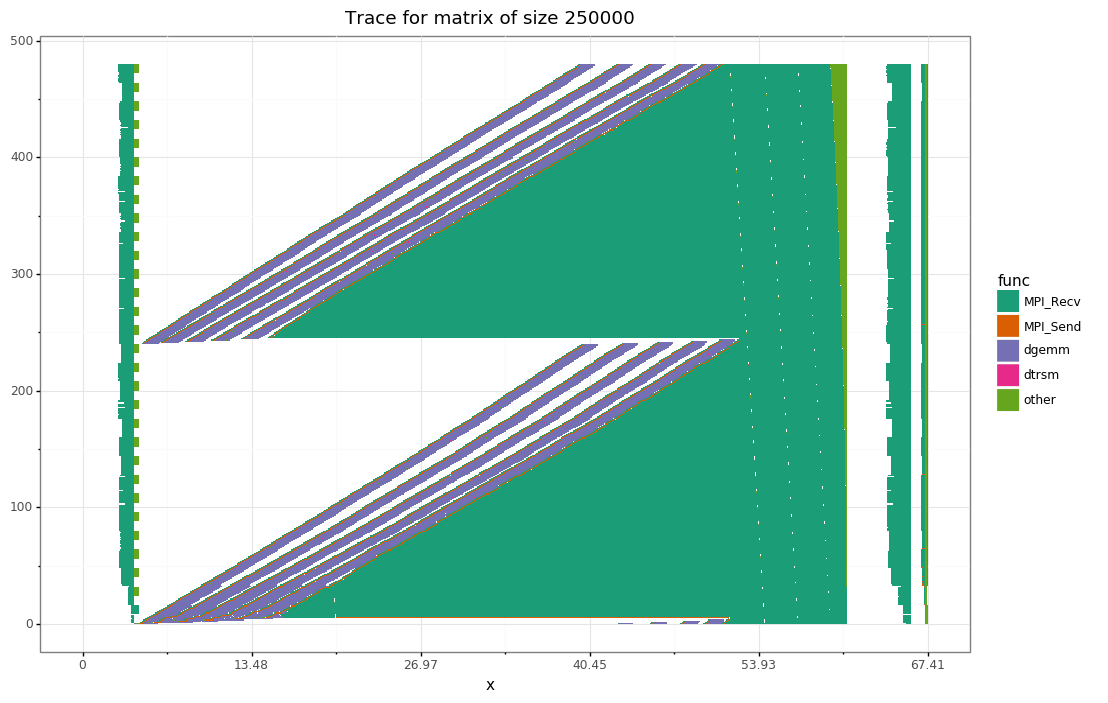

<ggplot: (-9223363300348380430)>


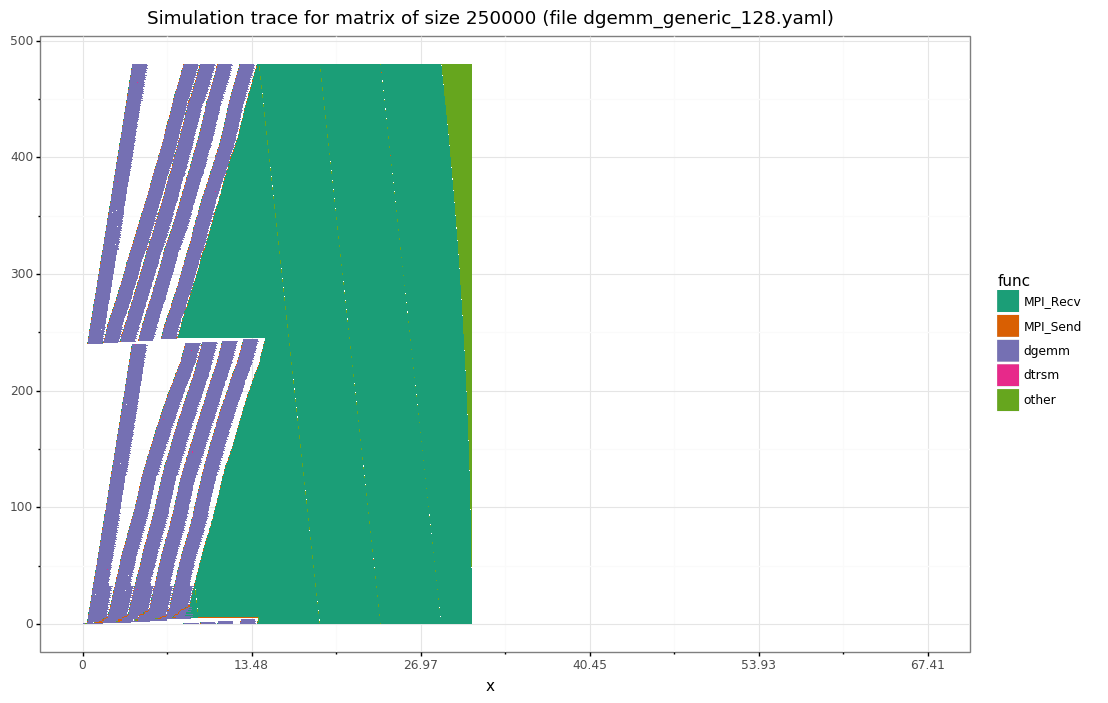

<ggplot: (8736503448584)>


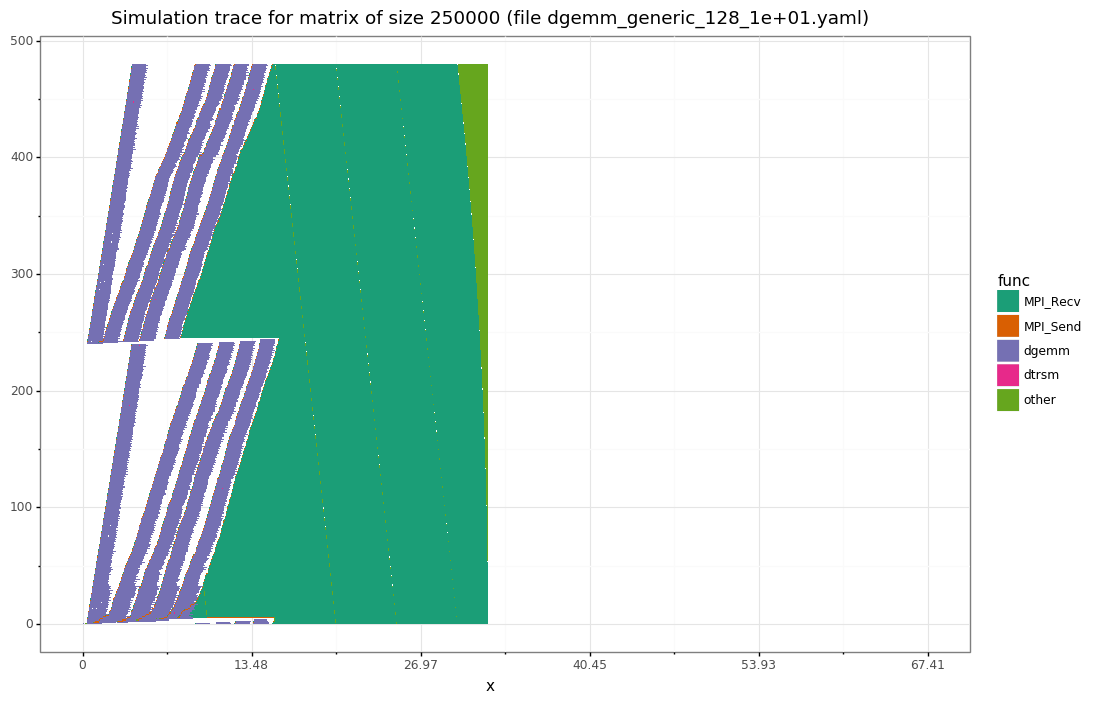

<ggplot: (8736484081654)>


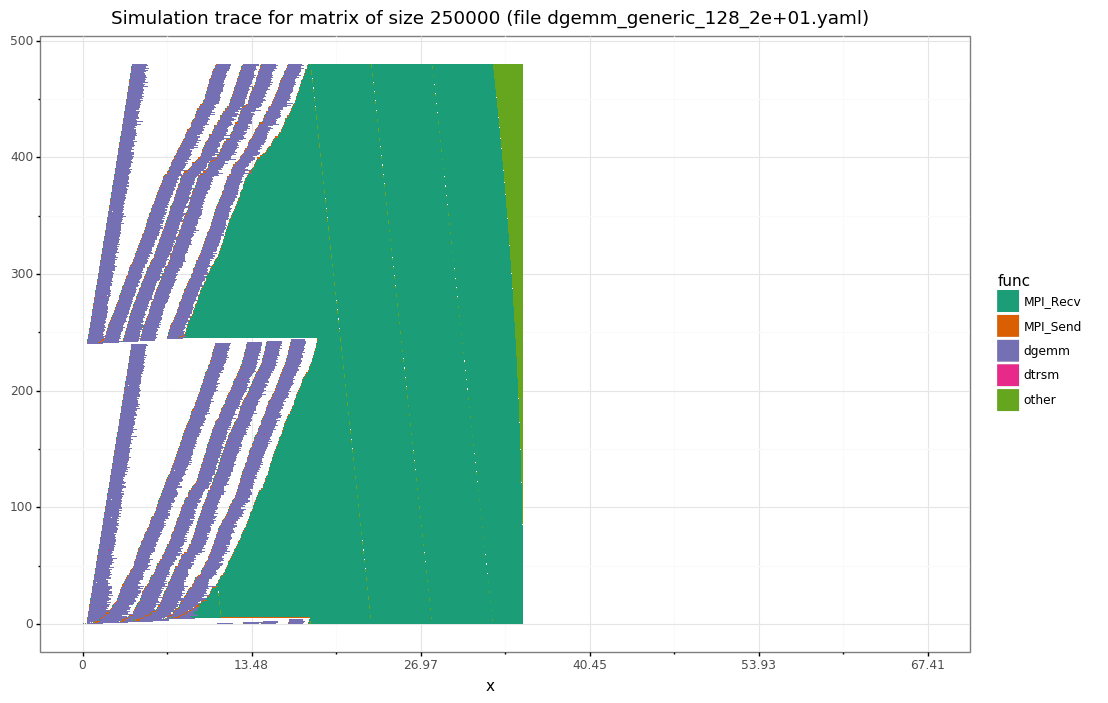

<ggplot: (-9223363300351314702)>


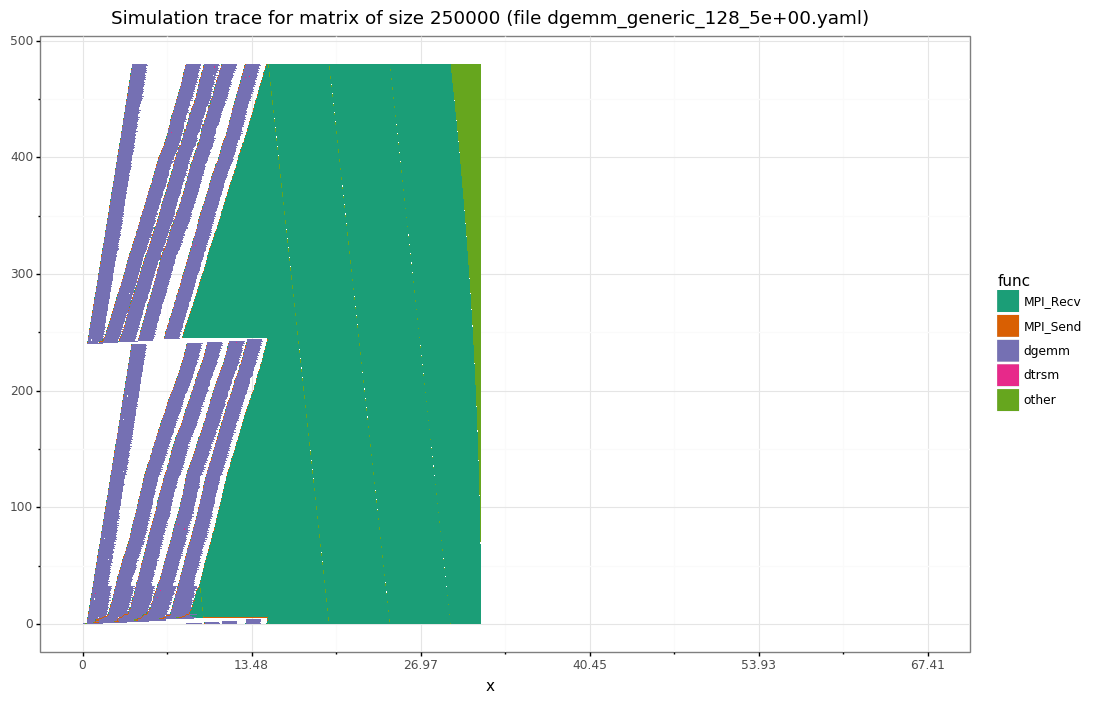

<ggplot: (8736487188733)>


In [12]:
for size in sorted(non_null_traces.matrix_size.unique()):
    tmp = non_null_traces[(non_null_traces['matrix_size'] == size)]
    lines = my_range(non_null_traces.start.min(), non_null_traces.start.max(), 4)
    print(plot(tmp[tmp['mode'] == 'reality'], lines=lines) + ggtitle('Trace for matrix of size %d' % size))
    for dgemm_file in sorted(traces[traces['mode'] != 'reality']['dgemm_file'].unique()):
        print(plot(tmp[(tmp['mode'] != 'reality') & (tmp['dgemm_file'] == dgemm_file)], lines=lines) + ggtitle('Simulation trace for matrix of size %d (file %s)' % (size, dgemm_file)))

## Null sizes

In [13]:
null_traces = traces[(traces['kind'] == 'BLAS') & ((traces['m'] == 0) | (traces['n'] == 0) | (traces['k'] == 0))]
null_traces.groupby(['mode', 'function', 'dgemm_file'])[['duration']].agg(['sum', 'count'])

duration        
                                                             sum   count
mode    function      dgemm_file                                        
simgrid HPL_dlaswp00N dgemm_generic_128.yaml        6.243500e-04   62435
                      dgemm_generic_128_1e+01.yaml  7.857270e-04   78573
                      dgemm_generic_128_2e+01.yaml  1.074248e-03  107425
                      dgemm_generic_128_5e+00.yaml  7.260600e-04   72606
        HPL_dlatcpy   dgemm_generic_128.yaml        3.600000e-07      36
                      dgemm_generic_128_1e+01.yaml  3.600000e-07      36
                      dgemm_generic_128_2e+01.yaml  3.600000e-07      36
                      dgemm_generic_128_5e+00.yaml  3.600000e-07      36
        dgemm         dgemm_generic_128.yaml        1.265418e+03   62813
                      dgemm_generic_128_1e+01.yaml  1.639319e+03   78951
                      dgemm_generic_128_2e+01.yaml  2.468161e+03  107803
                      dgemm_generic_128_5e+00.yaml  1.472663e+03   72984
        dtrsm         dgemm_generic_128.yaml        6.281300e-04   62813
                      dgemm_generic_128_1e+01.yaml  7.895100e-04   78951
                      dgemm_generic_128_2e+01.yaml  1.078030e-03  107803
                      dgemm_generic_128_5e+00.yaml  7.298380e-04   72984

In [14]:
null_traces

,dgemm_file,duration,end,file,function,k,kind,line,m,matrix_size,mode,msg_size,n,rank,rank+1,start,timestamp
12,dgemm_generic_128_2e+01.yaml,1.000000e-08,0.000437,NaN,HPL_dlatcpy,NaN,BLAS,0.0,0.0,250000,simgrid,-1,2.0,0,1,0.000437,0.000437
22,dgemm_generic_128_2e+01.yaml,1.000000e-08,0.000887,/tmp/hpl-2.2/src/pfact/HPL_pdrpanrlT.c,dtrsm,NaN,BLAS,172.0,0.0,250000,simgrid,-1,2.0,0,1,0.000887,0.000887
23,dgemm_generic_128_2e+01.yaml,6.785000e-04,0.001566,/tmp/hpl-2.2/src/pfact/HPL_pdrpanrlT.c,dgemm,2.0,BLAS,224.0,249996.0,250000,simgrid,-1,0.0,0,1,0.000887,0.000887
27,dgemm_generic_128_2e+01.yaml,1.000000e-08,0.002917,NaN,HPL_dlatcpy,NaN,BLAS,0.0,0.0,250000,simgrid,-1,4.0,0,1,0.002917,0.002917
49,dgemm_generic_128_2e+01.yaml,1.000000e-08,0.003814,/tmp/hpl-2.2/src/pfact/HPL_pdrpanrlT.c,dtrsm,NaN,BLAS,172.0,0.0,250000,simgrid,-1,2.0,0,1,0.003814,0.003814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262917,dgemm_generic_128_5e+00.yaml,1.000000e-08,6.990120,/tmp/hpl-2.2/src/pgesv/HPL_pdupdateTT.c,dtrsm,NaN,BLAS,184.0,128.0,250000,simgrid,-1,0.0,9,10,6.990120,6.990120
262918,dgemm_generic_128_5e+00.yaml,6.913177e-03,6.997033,/tmp/hpl-2.2/src/pgesv/HPL_pdupdateTT.c,dgemm,128.0,BLAS,202.0,249488.0,250000,simgrid,-1,0.0,9,10,6.990120,6.990120
262919,dgemm_generic_128_5e+00.yaml,1.000000e-08,6.997037,NaN,HPL_dlaswp00N,NaN,BLAS,0.0,128.0,250000,simgrid,-1,0.0,9,10,6.997037,6.997037
262920,dgemm_generic_128_5e+00.yaml,1.000000e-08,6.997037,/tmp/hpl-2.2/src/pgesv/HPL_pdupdateTT.c,dtrsm,NaN,BLAS,184.0,128.0,250000,simgrid,-1,0.0,9,10,6.997037,6.997037


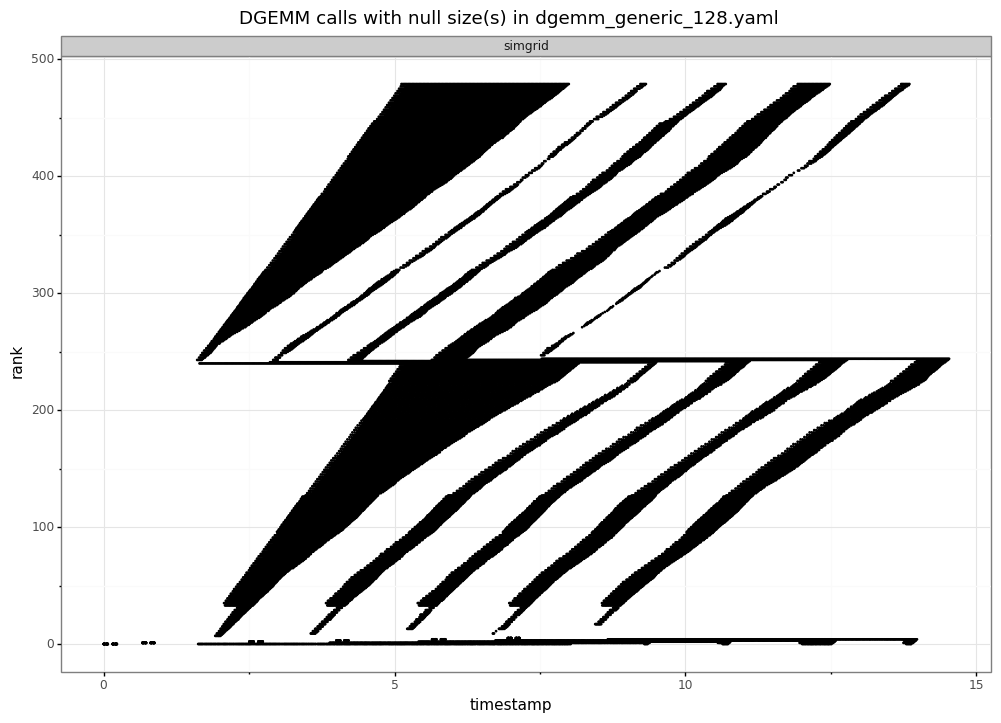

<ggplot: (8736486806185)>


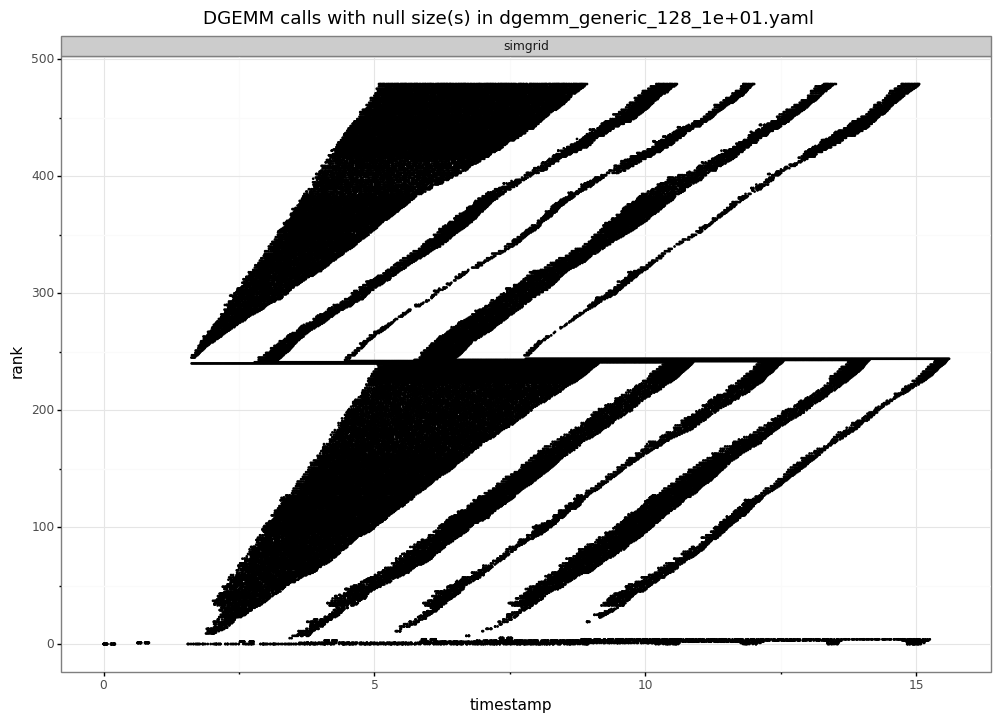

<ggplot: (-9223363300370688796)>


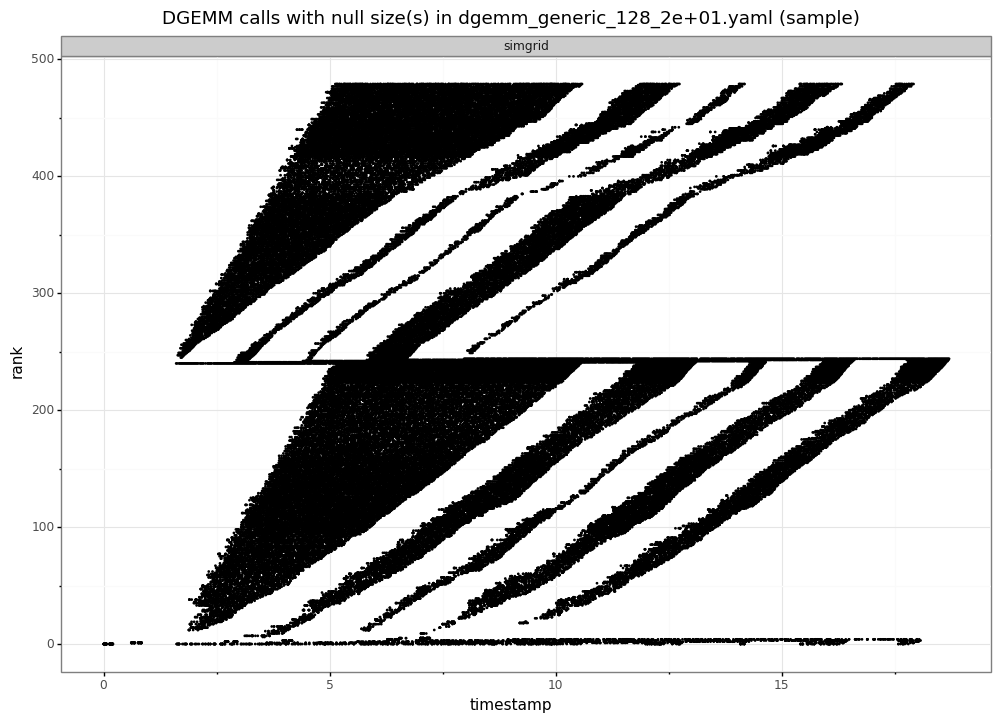

<ggplot: (-9223363300351048006)>


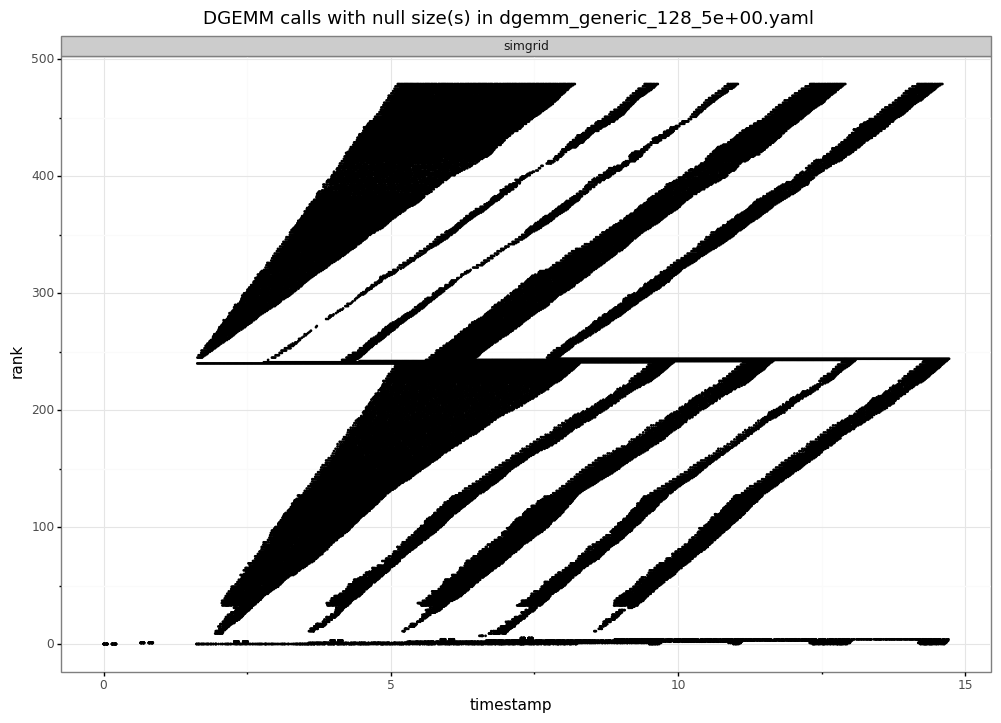

<ggplot: (-9223363300351314337)>


In [15]:
for dgemm_file in sorted(null_traces['dgemm_file'].unique()):
    tmp = null_traces[(null_traces['dgemm_file'] == dgemm_file) & (null_traces['function'] == 'dgemm')]
    try:
        tmp = tmp.sample(n=100000)
        sampled = True
    except ValueError:
        sampled = False
    print(ggplot(tmp)
        + aes(x='timestamp', y='rank')
        + geom_point(size=0.1)
        + facet_wrap('mode')
        + theme_bw()
        + ggtitle(f'DGEMM calls with null size(s) in {dgemm_file} {"(sample)" if sampled else ""}')
    )

In [16]:
null_dgemm = null_traces[null_traces['function'] == 'dgemm']
tmp = null_dgemm.groupby(['file', 'line', 'dgemm_file'])[['rank']].count().reset_index()
max_call = tmp[tmp['rank'] == tmp['rank'].max()].iloc[0]
print(max_call)
tmp

file          /tmp/hpl-2.2/src/pgesv/HPL_pdupdateTT.c
line                                              202
dgemm_file               dgemm_generic_128_2e+01.yaml
rank                                           107425
Name: 6, dtype: object


,file,line,dgemm_file,rank
0,/tmp/hpl-2.2/src/pfact/HPL_pdrpanrlT.c,224.0,dgemm_generic_128.yaml,378
1,/tmp/hpl-2.2/src/pfact/HPL_pdrpanrlT.c,224.0,dgemm_generic_128_1e+01.yaml,378
2,/tmp/hpl-2.2/src/pfact/HPL_pdrpanrlT.c,224.0,dgemm_generic_128_2e+01.yaml,378
3,/tmp/hpl-2.2/src/pfact/HPL_pdrpanrlT.c,224.0,dgemm_generic_128_5e+00.yaml,378
4,/tmp/hpl-2.2/src/pgesv/HPL_pdupdateTT.c,202.0,dgemm_generic_128.yaml,62435
5,/tmp/hpl-2.2/src/pgesv/HPL_pdupdateTT.c,202.0,dgemm_generic_128_1e+01.yaml,78573
6,/tmp/hpl-2.2/src/pgesv/HPL_pdupdateTT.c,202.0,dgemm_generic_128_2e+01.yaml,107425
7,/tmp/hpl-2.2/src/pgesv/HPL_pdupdateTT.c,202.0,dgemm_generic_128_5e+00.yaml,72606


In [17]:
tmp = null_dgemm[(null_dgemm['file'].str.contains(max_call['file'][-10])) & (null_dgemm['line'] == max_call['line'])]

In [18]:
print(len(tmp[tmp['m'] == 0]))
print(len(tmp[tmp['n'] == 0]))
print(len(tmp[tmp['k'] == 0]))

0
321039
0


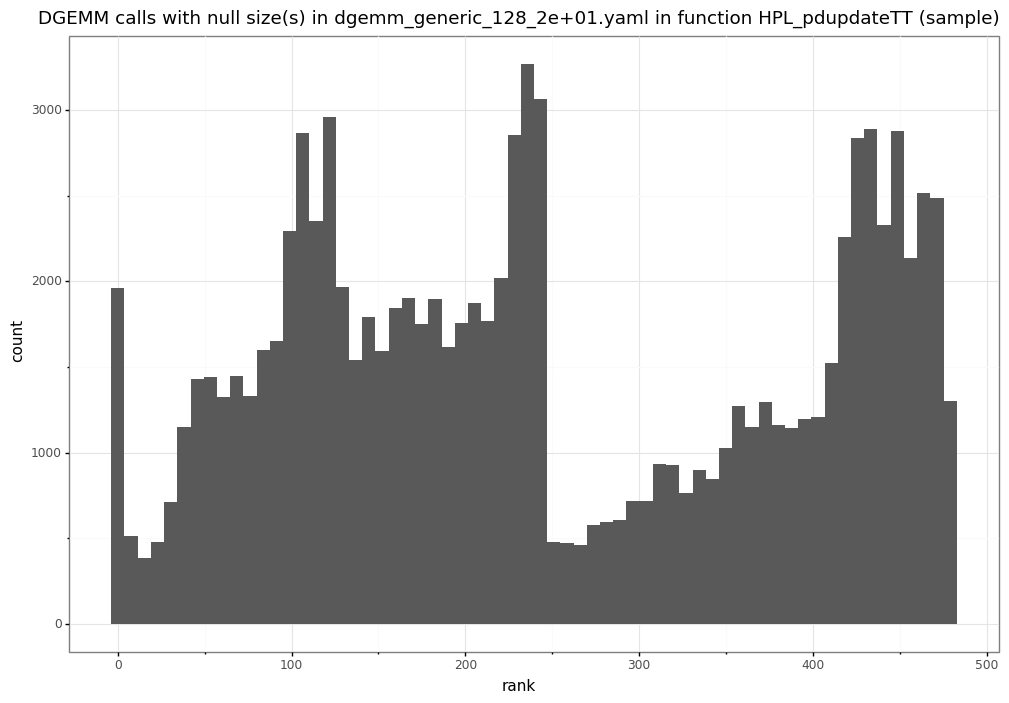

<ggplot: (8736503569700)>


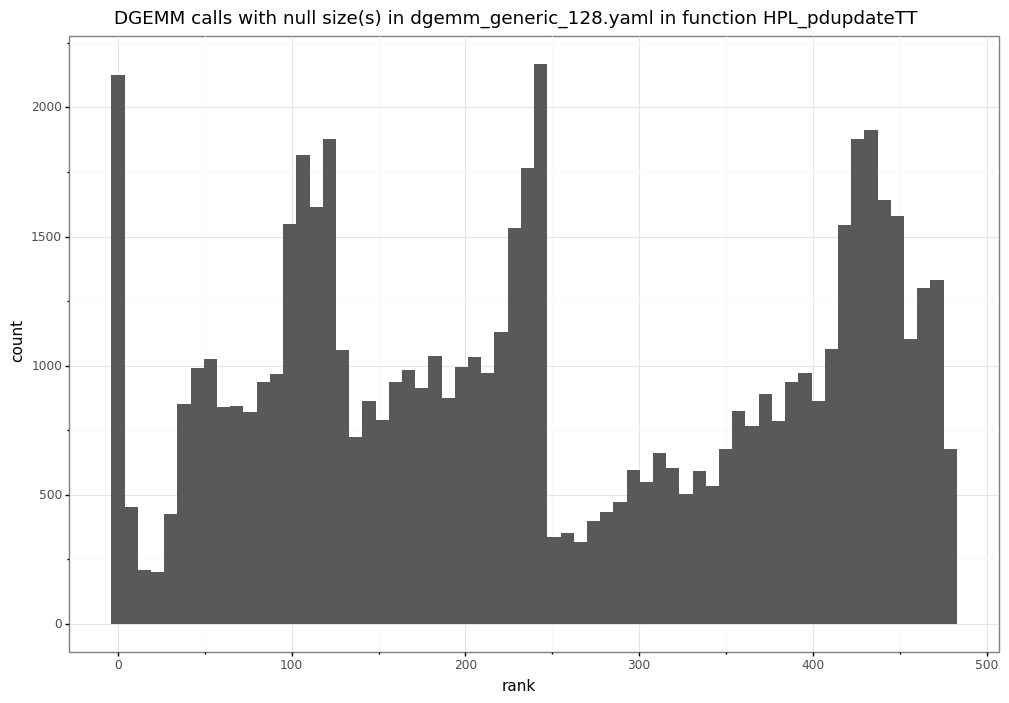

<ggplot: (-9223363300367078063)>


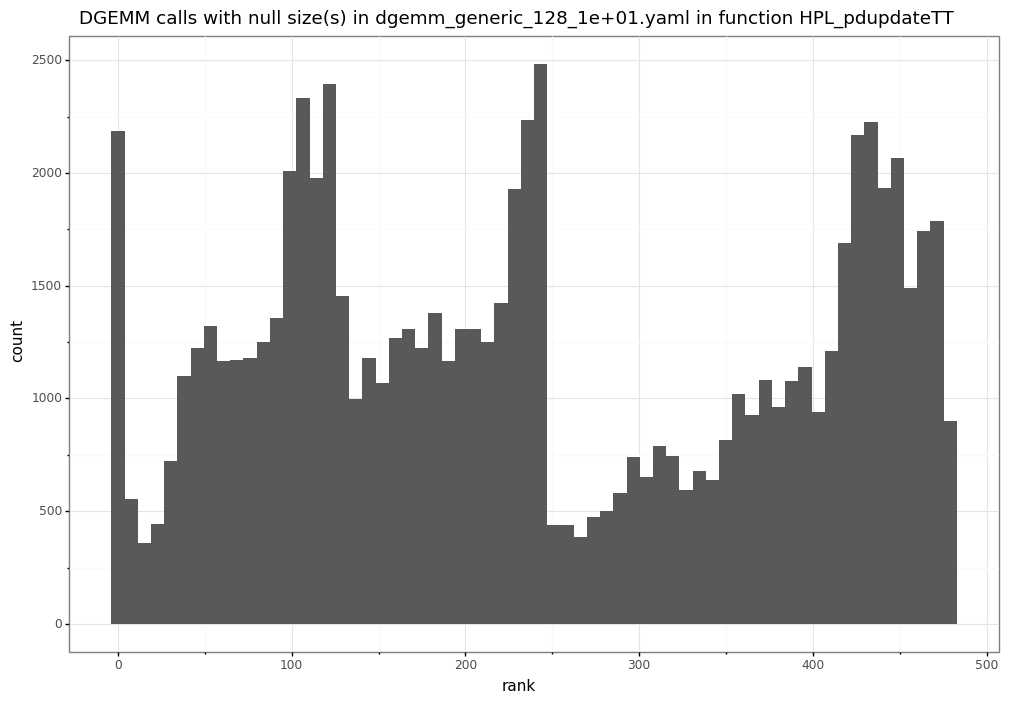

<ggplot: (-9223363300360765387)>


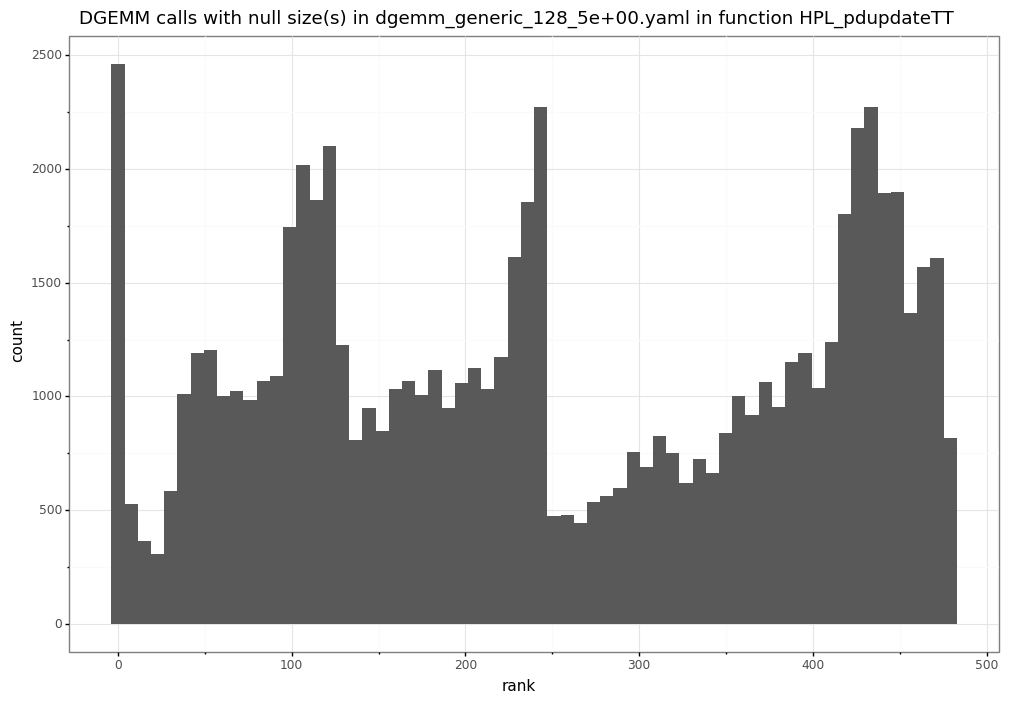

<ggplot: (-9223363300361046307)>


In [19]:
for dgemm_file in tmp['dgemm_file'].unique():
    tmp_mode = tmp[(tmp['dgemm_file'] == dgemm_file)]
    try:
        tmp_mode = tmp_mode.sample(n=100000)
        sampled = True
    except ValueError:
        sampled = False
    print(ggplot(tmp_mode)
        + aes(x='rank')
        + geom_histogram(bins=64)
        + theme_bw()
        + ggtitle(f'DGEMM calls with null size(s) in {dgemm_file} in function HPL_pdupdateTT {"(sample)" if sampled else ""}')
    )

## Work in-balance

In [20]:
non_null_dgemm = non_null_traces[non_null_traces['function'] == 'dgemm'].copy()
non_null_dgemm['mnk'] = non_null_dgemm['m'] * non_null_dgemm['n'] * non_null_dgemm['k']
non_null_dgemm['dgemm_file'] = non_null_dgemm['dgemm_file'].astype(str)
non_null_dgemm.loc[non_null_dgemm['mode'] == 'reality', 'dgemm_file'] = 'reality'

grouped = non_null_dgemm.groupby(['rank', 'mode', 'dgemm_file'])[['duration', 'mnk']].sum().reset_index()
grouped['gflops'] = 2*grouped['mnk'] / grouped['duration'] * 1e-9
grouped.head()

,rank,mode,dgemm_file,duration,mnk,gflops
0,0,reality,reality,6.027826,8.380965e+10,27.807588
1,0,simgrid,dgemm_generic_128.yaml,6.322132,8.380965e+10,26.513100
2,0,simgrid,dgemm_generic_128_1e+01.yaml,6.064153,8.380965e+10,27.641010
3,0,simgrid,dgemm_generic_128_2e+01.yaml,6.126852,8.380965e+10,27.358147
4,0,simgrid,dgemm_generic_128_5e+00.yaml,6.278640,8.380965e+10,26.696756


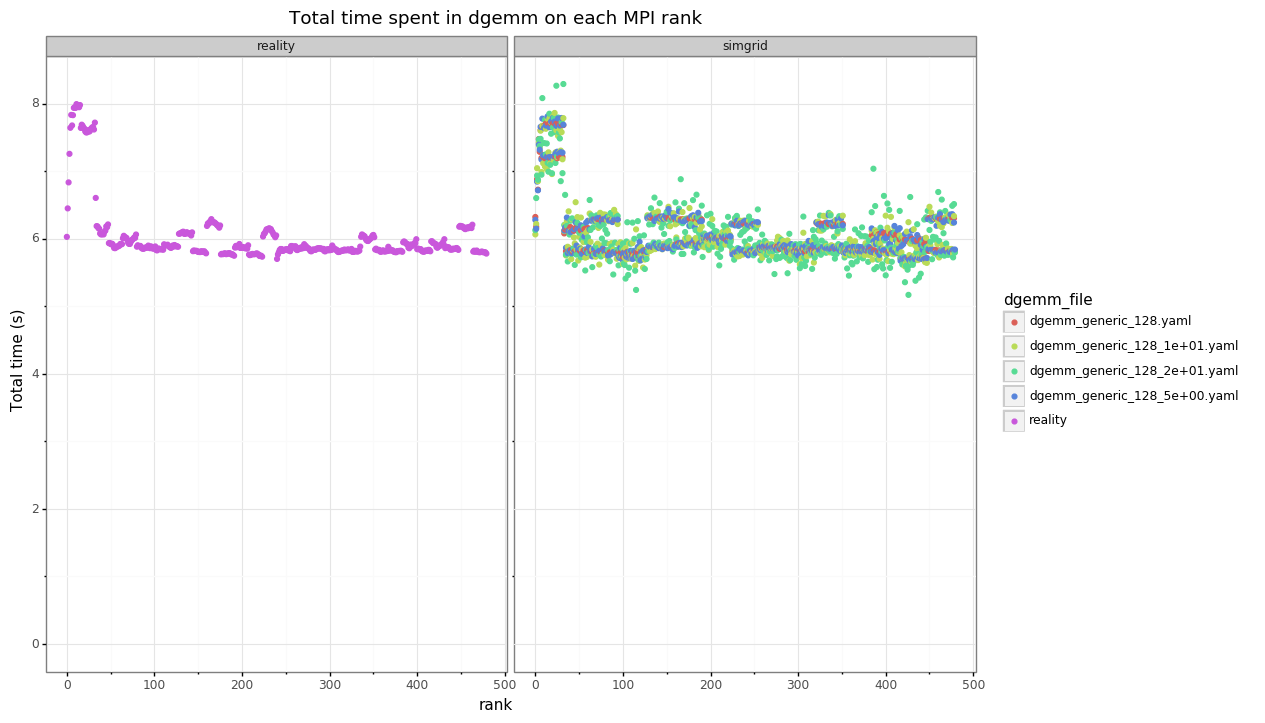

<ggplot: (8736493577725)>

In [21]:
plot = ggplot(grouped) + aes(x='rank', y='duration', color='dgemm_file') + geom_point() + facet_wrap('mode')
plot = plot + theme_bw() + ggtitle('Total time spent in dgemm on each MPI rank') + ylab('Total time (s)') + expand_limits(y=0)
plot

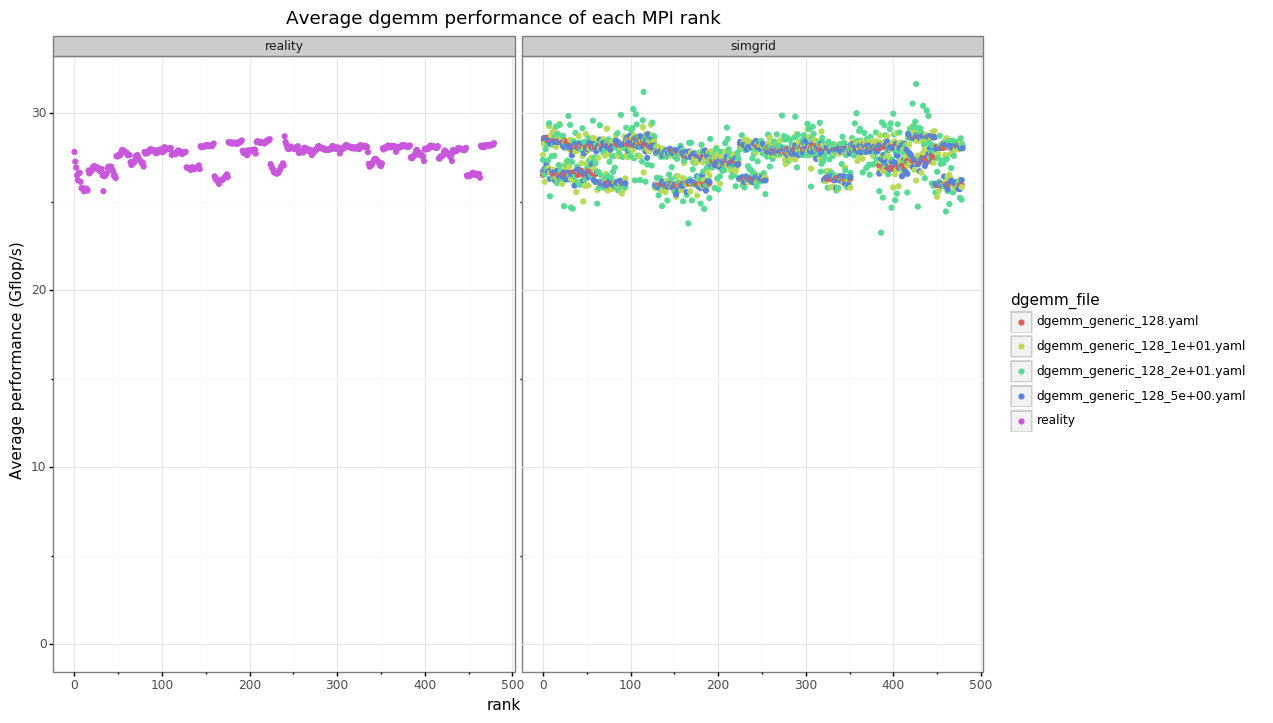

<ggplot: (-9223363300367993782)>

In [22]:
plot = ggplot(grouped) + aes(x='rank', y='gflops', color='dgemm_file') + geom_point() + facet_wrap('mode') + expand_limits(y=0)
plot = plot + theme_bw() + ggtitle('Average dgemm performance of each MPI rank') + ylab('Average performance (Gflop/s)')
plot

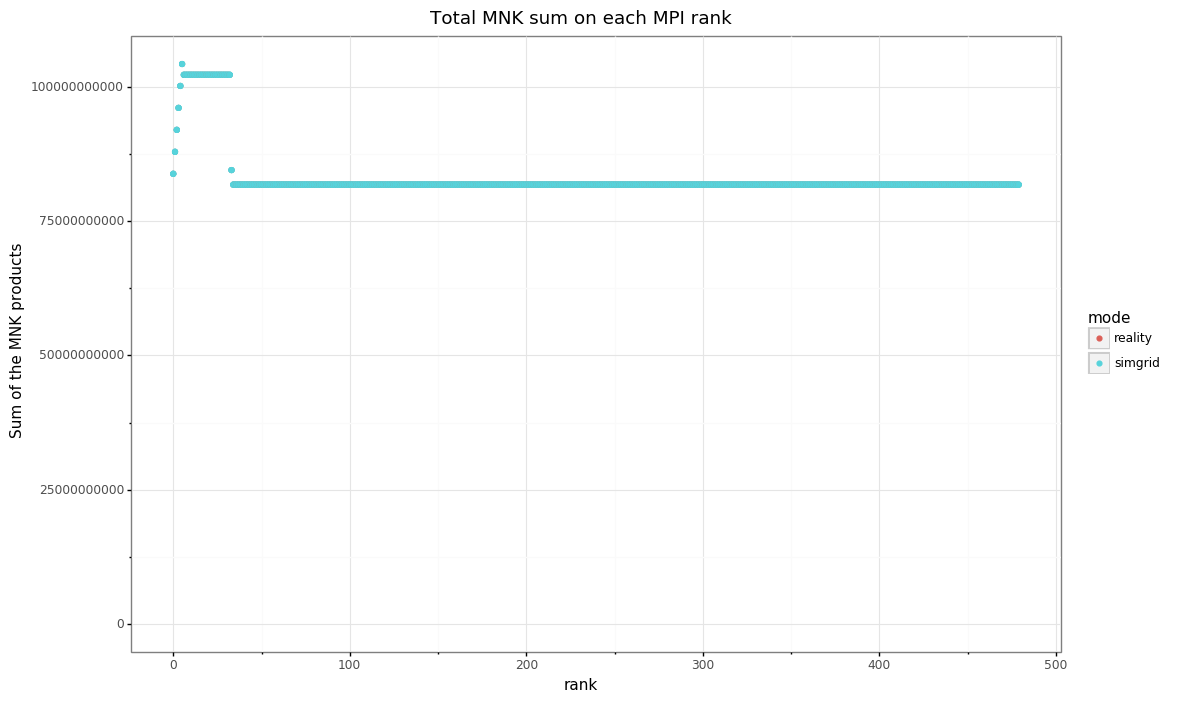

<ggplot: (8736503500201)>

In [23]:
plot = ggplot(grouped) + aes(x='rank', y='mnk', color='mode') + geom_point()
plot = plot + theme_bw() + ggtitle('Total MNK sum on each MPI rank') + ylab('Sum of the MNK products') + expand_limits(y=0)
plot

## DGEMM variability (most variable model)

In [24]:
expfiles = get_yaml(simgrid_archives[0], 'info.yaml')['expfile']
dgemm_model = [f for f in expfiles if f.endswith('.yaml')]
print(dgemm_model)
assert len(dgemm_model) == 1
dgemm_model = get_yaml(simgrid_archives[0], dgemm_model[0])

/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:21: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


['dgemm_generic_128_2e+01.yaml']


In [25]:
tmp = traces[(traces['function'] == 'dgemm') & (traces['n'] != 0)].copy().reset_index(drop=True)
tmp['prod'] = tmp['m'] * tmp['n'] * tmp['k']
tmp['gflops'] = 2e-9*tmp['prod'] / tmp['duration']

In [26]:
tmp['node'] = tmp['rank'] // 32 + 1
tmp['cpu'] = tmp['rank'] % 2
tmp['cpu_id'] = tmp['node'] * 2 + tmp['cpu']
tmp['cpu_id'].unique()

array([ 2,  8,  9,  3, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23,  4,  5, 24, 25, 26, 27, 28, 29, 30, 31,  6,  7])

In [27]:
import numpy

tmp['raw_duration'] = -1
tmp['noise_std'] = 0
tmp['mnk'] = tmp['prod']
tmp['mn'] = tmp['m'] * tmp['n']
tmp['mk'] = tmp['m'] * tmp['k']
tmp['nk'] = tmp['n'] * tmp['k']
for node in dgemm_model['model']:
    tmp.loc[tmp['cpu_id'] == node['cpu_id'], 'raw_duration'] = node['intercept']
    for arg in ['mnk', 'mn', 'nk', 'mk']:
        tmp.loc[tmp['cpu_id'] == node['cpu_id'], 'raw_duration'] += node[arg] * tmp[arg]
    tmp.loc[tmp['cpu_id'] == node['cpu_id'], 'noise_std'] = node['intercept_residual']
    for arg in ['mnk', 'mn', 'nk', 'mk']:
        tmp.loc[tmp['cpu_id'] == node['cpu_id'], 'noise_std'] += node[f'{arg}_residual'] * tmp[arg]

tmp['raw_gflops'] = 2e-9*tmp['prod'] / tmp['raw_duration']
tmp['sigma'] = tmp['noise_std'] / numpy.sqrt(1-2/numpy.pi)
tmp['mu'] = tmp['raw_duration'] - tmp['sigma']*numpy.sqrt(2/numpy.pi)
tmp['duration_sim'] = abs(numpy.random.normal(size=len(tmp))) * tmp['sigma'] + tmp['mu']
tmp

,dgemm_file,duration,end,file,function,k,kind,line,m,matrix_size,...,raw_duration,noise_std,mnk,mn,mk,nk,raw_gflops,sigma,mu,duration_sim
0,NaN,0.000839,4.105255,../HPL_pdrpanrlT.c,dgemm,2.0,BLAS,224.0,249998.0,250000,...,0.000167,0.000587,9.999920e+05,499996.0,499996.0,4.0,11.988979,0.000975,-0.000611,-0.000469
1,NaN,0.001645,4.107865,../HPL_pdrpanrlT.c,dgemm,4.0,BLAS,224.0,249996.0,250000,...,0.000479,0.001175,3.999936e+06,999984.0,999984.0,16.0,16.699838,0.001949,-0.001076,0.001467
2,NaN,0.000817,4.109808,../HPL_pdrpanrlT.c,dgemm,2.0,BLAS,224.0,249994.0,250000,...,0.000167,0.000587,9.999760e+05,499988.0,499988.0,4.0,11.988976,0.000975,-0.000611,-0.000476
3,NaN,0.003198,4.113797,../HPL_pdrpanrlT.c,dgemm,8.0,BLAS,224.0,249992.0,250000,...,0.001547,0.002369,1.599949e+07,1999936.0,1999936.0,64.0,20.682023,0.003929,-0.001588,0.003073
4,NaN,0.000835,4.115624,../HPL_pdrpanrlT.c,dgemm,2.0,BLAS,224.0,249990.0,250000,...,0.000167,0.000587,9.999600e+05,499980.0,499980.0,4.0,11.988973,0.000974,-0.000611,0.000660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50482,dgemm_generic_128_5e+00.yaml,0.278797,7.323260,/tmp/hpl-2.2/src/pgesv/HPL_pdupdateTT.c,dgemm,128.0,BLAS,202.0,249360.0,250000,...,0.287985,0.050088,4.085514e+09,31918080.0,31918080.0,16384.0,28.373095,0.083090,0.221689,0.244890
50483,dgemm_generic_128_5e+00.yaml,0.280139,7.603521,/tmp/hpl-2.2/src/pgesv/HPL_pdupdateTT.c,dgemm,128.0,BLAS,202.0,249360.0,250000,...,0.287985,0.050088,4.085514e+09,31918080.0,31918080.0,16384.0,28.373095,0.083090,0.221689,0.265464
50484,dgemm_generic_128_5e+00.yaml,0.277992,7.881627,/tmp/hpl-2.2/src/pgesv/HPL_pdupdateTT.c,dgemm,128.0,BLAS,202.0,249360.0,250000,...,0.287985,0.050088,4.085514e+09,31918080.0,31918080.0,16384.0,28.373095,0.083090,0.221689,0.247595
50485,dgemm_generic_128_5e+00.yaml,0.302214,8.183957,/tmp/hpl-2.2/src/pgesv/HPL_pdupdateTT.c,dgemm,128.0,BLAS,202.0,249360.0,250000,...,0.287985,0.050088,4.085514e+09,31918080.0,31918080.0,16384.0,28.373095,0.083090,0.221689,0.264239


In [28]:
foo = tmp[(tmp['mode'] == 'simgrid') & (tmp['rank'] == 0)]
foo = foo[foo['mnk'] == foo['mnk'].max()]
foo[['m', 'n', 'k', 'prod', 'mn', 'nk', 'mk', 'duration', 'raw_duration', 'duration_sim']]

,m,n,k,prod,mn,nk,mk,duration,raw_duration,duration_sim
10159,249872.0,128.0,128.0,4.093903e+09,31983616.0,16384.0,31983616.0,0.283514,0.308552,0.349667
10160,249872.0,128.0,128.0,4.093903e+09,31983616.0,16384.0,31983616.0,0.322320,0.308552,0.368107
10161,249872.0,128.0,128.0,4.093903e+09,31983616.0,16384.0,31983616.0,0.339645,0.308552,0.392680
10162,249872.0,128.0,128.0,4.093903e+09,31983616.0,16384.0,31983616.0,0.307367,0.308552,0.258978
20256,249872.0,128.0,128.0,4.093903e+09,31983616.0,16384.0,31983616.0,0.307300,0.308552,0.257061
20257,249872.0,128.0,128.0,4.093903e+09,31983616.0,16384.0,31983616.0,0.309282,0.308552,0.330050
20258,249872.0,128.0,128.0,4.093903e+09,31983616.0,16384.0,31983616.0,0.312947,0.308552,0.261062
20259,249872.0,128.0,128.0,4.093903e+09,31983616.0,16384.0,31983616.0,0.305905,0.308552,0.337287
30349,249872.0,128.0,128.0,4.093903e+09,31983616.0,16384.0,31983616.0,0.296033,0.308552,0.313254
30350,249872.0,128.0,128.0,4.093903e+09,31983616.0,16384.0,31983616.0,0.301422,0.308552,0.326676


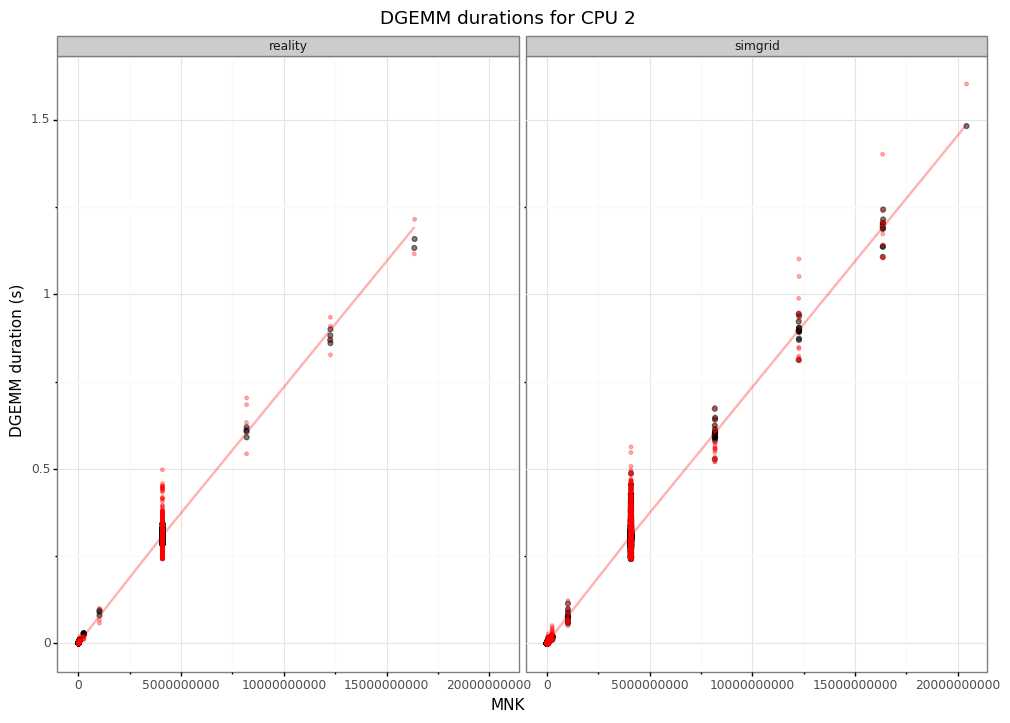

<ggplot: (8736494520177)>


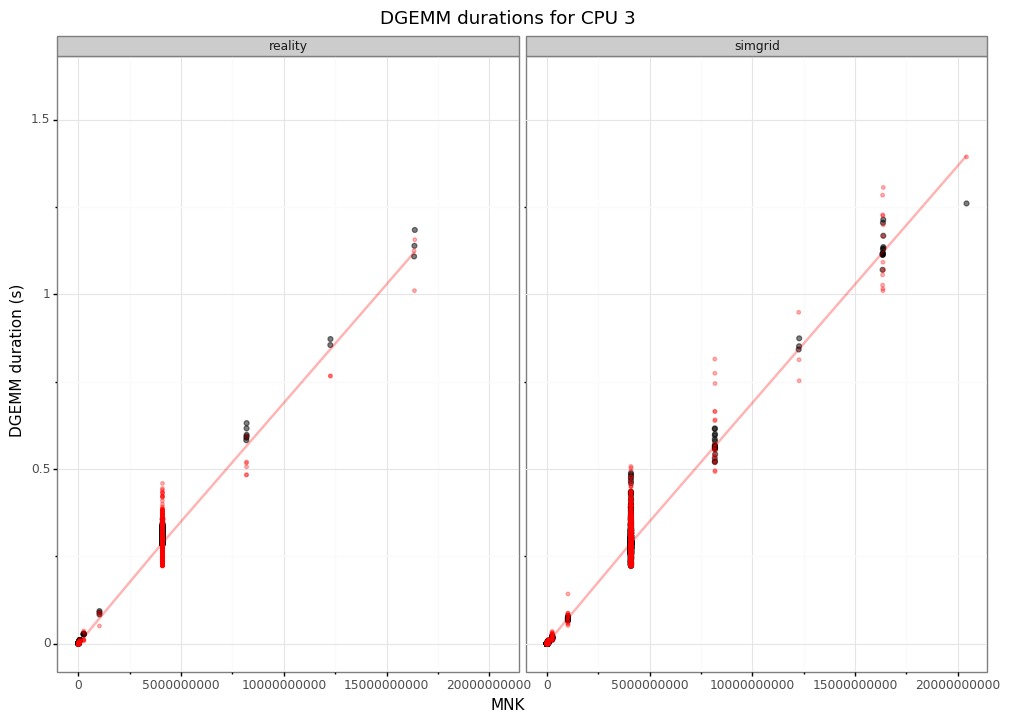

<ggplot: (8736487054817)>


In [29]:
max_prod = tmp['prod'].max()
max_time = max(tmp['duration'].max(), tmp['duration_sim'].max())
for cpu_id in [2, 3]:
    print(ggplot(tmp[tmp['cpu_id'] == cpu_id])
     + aes(x='prod', y='duration')
     + facet_wrap('mode')
     + geom_point(alpha=0.5)
     + geom_point(aes(y='duration_sim'), color='red', alpha=0.3, size=1)
     + geom_line(aes(y='raw_duration'), color='red', alpha=0.3, size=1)
     + theme_bw()
     + expand_limits(x=0, y=0)
     + expand_limits(x=max_prod, y=max_time)
     + labs(x='MNK', y='DGEMM duration (s)')
     + ggtitle('DGEMM durations for CPU %d' % cpu_id)
    )

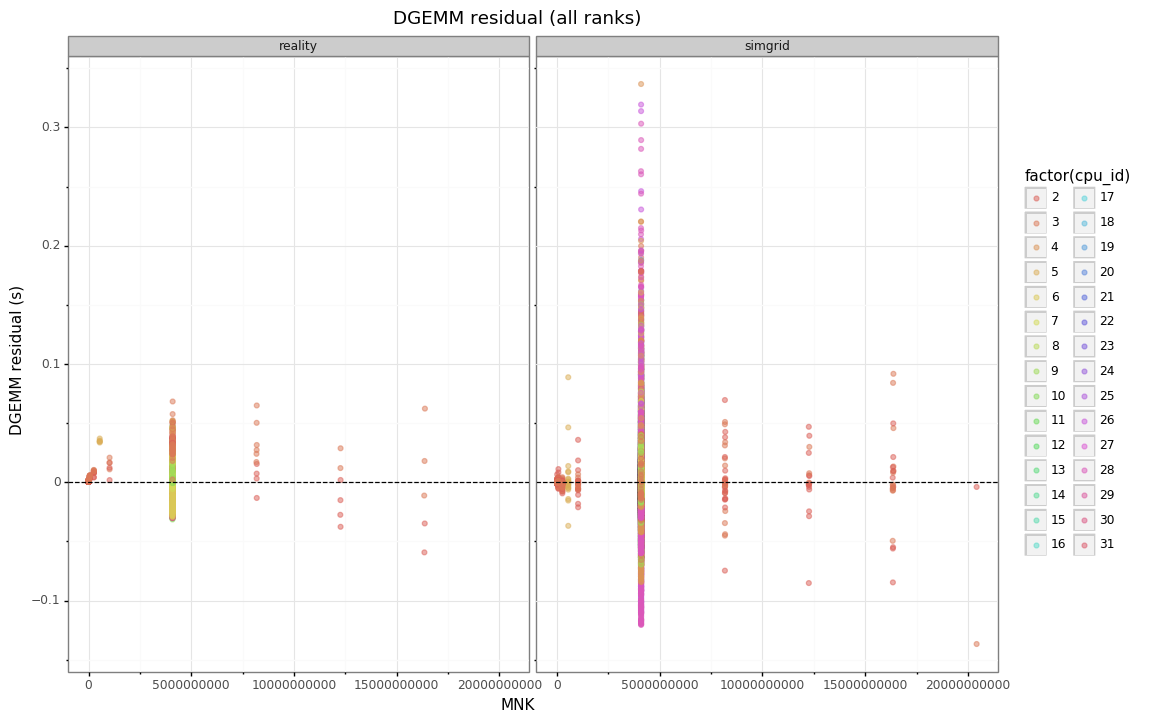

<ggplot: (-9223363300367751322)>

In [30]:
tmp['residual'] = tmp['duration'] - tmp['raw_duration']
(ggplot(tmp)
     + aes(x='prod', y='residual', color='factor(cpu_id)')
     + facet_wrap('mode')
     + geom_point(alpha=0.5)
     + geom_hline(yintercept=0, linetype='dashed')
     + theme_bw()
     + expand_limits(y=0, x=0)
     + expand_limits(x=max_prod)
     + labs(x='MNK', y='DGEMM residual (s)')
     + ggtitle('DGEMM residual (all ranks)')
    )

## Number of distinct MNK products

In [31]:
df = []
for cpu in sorted(tmp['cpu_id'].unique()):
    df.append({'cpu': cpu, 'nb_unique': len(tmp[tmp['cpu_id'] == cpu]['mnk'].unique())})
df = pandas.DataFrame(df)
df.sort_values(by='cpu')

,cpu,nb_unique
0,2,209
1,3,208
2,4,5
3,5,10
4,6,5
5,7,5
6,8,5
7,9,5
8,10,5
9,11,5
